In [ ]:
!pip install librosa soundfile speechrecognition pyttsx3 seaborn scikit-learn matplotlib openai-whisper pandas numpy nltk gTTS


In [ ]:
!apt-get install -y ffmpeg

In [6]:
from gtts import gTTS
import os

# === STEP 1: Generate Sample Audio Files with Task Mapping ===
def generate_voice_samples():
    os.makedirs("voice_samples", exist_ok=True)

    samples = [
        ("Um... I was going to the, uh, the place where we usually go, but I forgot what it's called.",
         "recall", ["park", "restaurant", "clinic"]),
        ("I went to the grocery store today and bought some apples and oranges.",
         "recall", ["apples", "oranges"]),
        ("Uh, yesterday, I think I, um, misplaced my keys and couldn’t find the, uh, right drawer.",
         "naming", ["keys", "drawer"]),
        ("I had lunch with my friend, and we talked about our college days.",
         "recall", ["college", "friend", "lunch"]),
        ("Er... What was I saying? Oh right, the, uh, medication time was missed again.",
         "completion", ["medication"]),
        ("Today I cleaned the room, washed clothes, and made tea. Felt good.",
         "naming", ["room", "clothes", "tea"]),
        ("I... I forgot the name of the... the doctor we usually visit.",
         "recall", ["doctor"]),
        ("My son called today. We had a nice talk about his new job in the city.",
         "recall", ["son", "job", "city"]),
        ("Ah... I think I left the stove on. Or maybe not. I don’t remember.",
         "completion", ["stove"]),
        ("Went for a walk in the park. The flowers are blooming beautifully.",
         "naming", ["park", "flowers"])
    ]

    for i, (txt, task_type, expected_words) in enumerate(samples):
        mp3_path = f"voice_samples/temp_{i+1}.mp3"
        wav_path = f"voice_samples/sample_{i+1}.wav"
        tts = gTTS(text=txt)
        tts.save(mp3_path)
        os.system(f"ffmpeg -loglevel quiet -y -i {mp3_path} {wav_path}")
        os.remove(mp3_path)
        with open(f"voice_samples/sample_{i+1}.meta", "w") as f:
            f.write(f"{task_type}|{','.join(expected_words)}")

    print("✅ Sample audio files and metadata generated.")

generate_voice_samples()

✅ Sample audio files and metadata generated.


In [7]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [15]:
# === IMPORTS ===
import os
import re
import whisper
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# === INIT ===
whisper_model = whisper.load_model("base")

# ========== FEATURE EXTRACTION FUNCTION ==========
def extract_features(audio_path):
    # Load audio
    audio, sr = librosa.load(audio_path, sr=16000)
    duration = librosa.get_duration(y=audio, sr=sr)

    # Detect silences
    non_silent_intervals = librosa.effects.split(audio, top_db=30)
    silence_durations = []
    prev_end = 0
    for start, end in non_silent_intervals:
        silence = (start - prev_end) / sr
        if silence > 0.3:
            silence_durations.append(silence)
        prev_end = end

    # Pitch variability
    pitches, _ = librosa.piptrack(y=audio, sr=sr)
    pitch_values = pitches[pitches > 0]
    pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0

    # Transcribe using Whisper
    result = whisper_model.transcribe(audio_path)
    transcript = result["text"]
    word_tokens = nltk.word_tokenize(transcript)
    word_count = len(word_tokens)
    transcript_lower = transcript.lower()

    # Speech rate
    speech_rate = word_count / duration if duration > 0 else 0

    # Hesitations
    hesitation_count = len(re.findall(r'\b(uh+|um+|erm+)\b', transcript_lower))

    # ==== Task Metadata Analysis ====
    meta_file = audio_path.replace(".wav", ".meta")
    task_type = None
    expected_words = []
    task_score = 0

    if os.path.exists(meta_file):
        with open(meta_file) as f:
            parts = f.read().strip().split("|")
            task_type = parts[0]
            expected_words = parts[1].split(",") if len(parts) > 1 else []

        if expected_words:
            hits = sum(1 for word in expected_words if word in transcript_lower)
            if task_type in ["recall", "naming"]:
                task_score = hits / len(expected_words)
            elif task_type == "completion":
                task_score = 1 if hits > 0 else 0

    # Return features
    return {
        "file": os.path.basename(audio_path),
        "duration": duration,
        "speech_rate": speech_rate,
        "avg_silence": np.mean(silence_durations) if silence_durations else 0,
        "pause_count": len(silence_durations),
        "pitch_std": pitch_std,
        "hesitations": hesitation_count,
        "task_score": task_score,
        "task_type": task_type,
        "transcript": transcript
    }

# ========== BATCH PROCESSING ==========
def process_audio_folder(folder_path):
    all_features = []
    for file in os.listdir(folder_path):
        if file.endswith(".wav") or file.endswith(".mp3"):
            print("Processing:", file)
            features = extract_features(os.path.join(folder_path, file))
            all_features.append(features)
    return pd.DataFrame(all_features)

# ========== RUN PIPELINE ==========
folder = "voice_samples"
df = process_audio_folder(folder)

# ========== ISOLATION FOREST ==========
features_for_model = [
    "speech_rate",
    "avg_silence",
    "pitch_std",
    "hesitations",
    "task_score"
]

print("\n🔍 Feature Inputs:")
print(df[features_for_model])

# Standardize and fit
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features_for_model])

iso_model = IsolationForest(contamination=0.2, random_state=42)
iso_model.fit(X_scaled)

df["anomaly_score"] = iso_model.decision_function(X_scaled)
df["risk_flag"] = iso_model.predict(X_scaled)

# Show results
print("\n📊 Final Results:")
print(df[["file", "anomaly_score", "risk_flag", "task_score"]])

# ========== OPTIONAL: Save to CSV ==========
df.to_csv("voice_analysis_results.csv", index=False)


Processing: sample_5.wav
Processing: sample_8.wav
Processing: sample_7.wav
Processing: sample_9.wav
Processing: sample_2.wav
Processing: sample_3.wav
Processing: sample_6.wav
Processing: sample_10.wav
Processing: sample_1.wav
Processing: sample_4.wav

🔍 Feature Inputs:
   speech_rate  avg_silence    pitch_std  hesitations  task_score
0     2.965044        0.000   874.276184            1         1.0
1     3.232759        0.000   956.276489            0         1.0
2     3.004808        0.000   945.192017            0         1.0
3     3.614916        0.352   736.808716            0         1.0
4     2.804487        0.000   907.712280            0         1.0
5     3.134796        0.000   860.381165            2         1.0
6     2.790179        0.832  1041.722168            0         1.0
7     2.961083        0.512   937.134766            0         1.0
8     3.642191        0.000   836.554932            2         0.0
9     3.172589        0.000  1009.806580            0         1.0

📊 F

# ========== VISUALIZATIONS ==========

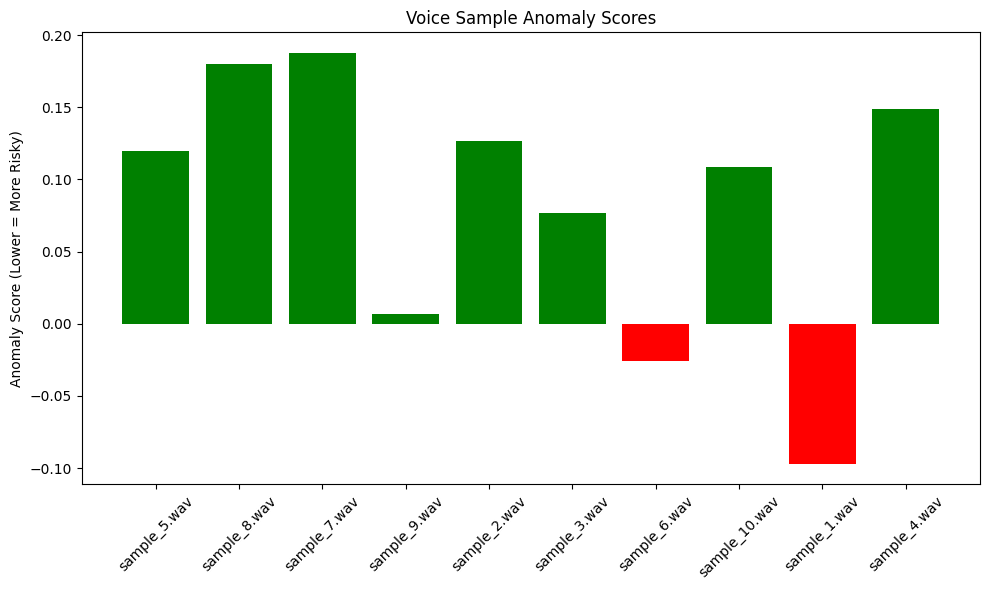

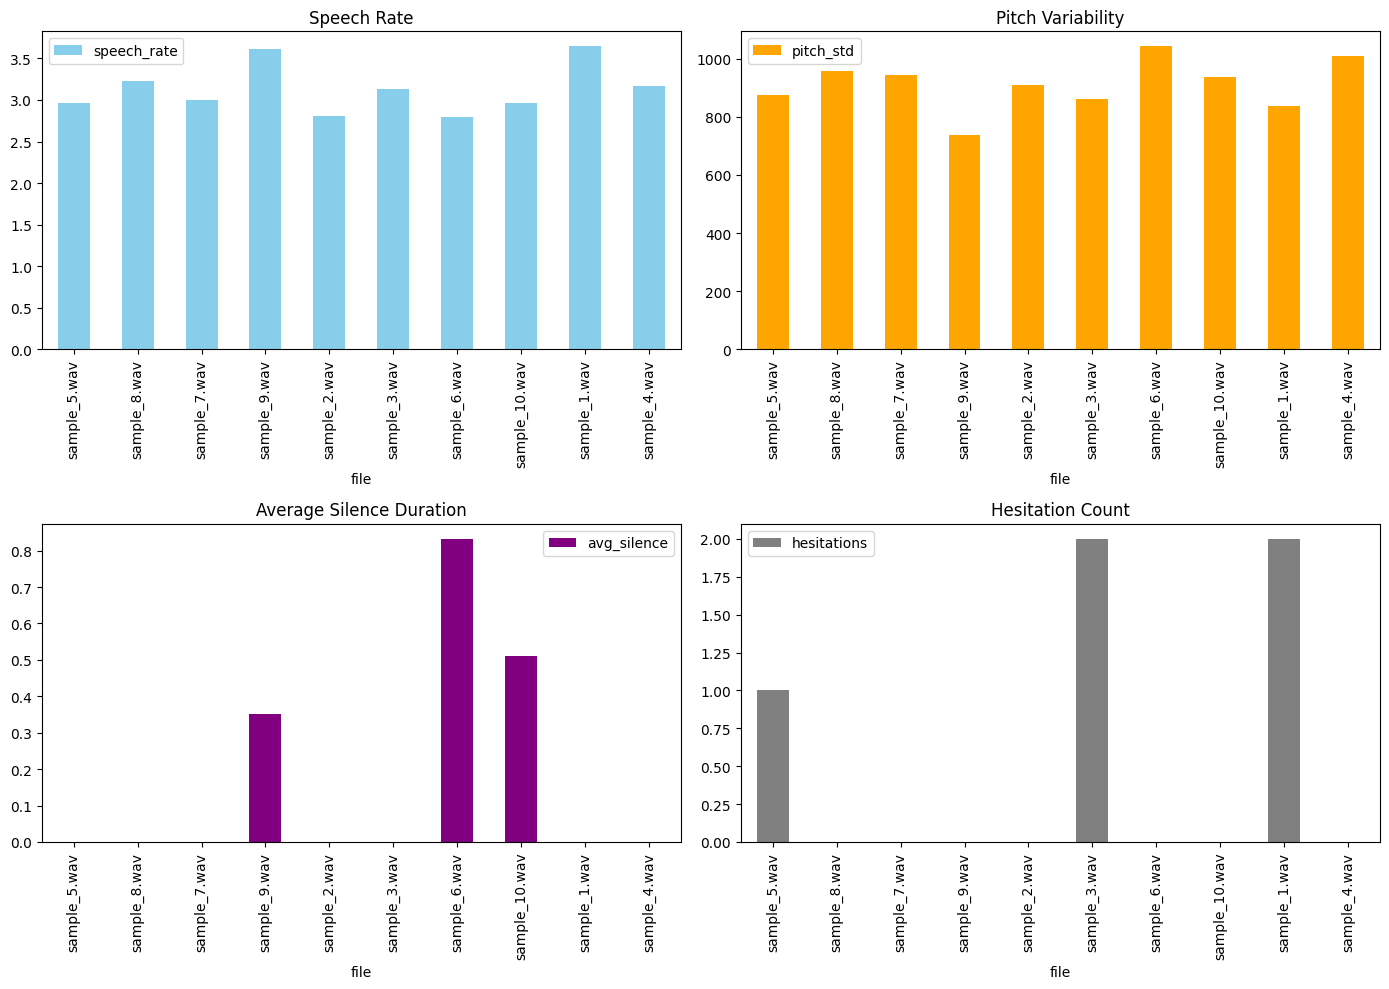

In [16]:
# 1. Bar chart of anomaly scores
plt.figure(figsize=(10,6))
plt.bar(df["file"], df["anomaly_score"], color=["red" if x == -1 else "green" for x in df["risk_flag"]])
plt.title("Voice Sample Anomaly Scores")
plt.ylabel("Anomaly Score (Lower = More Risky)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Feature comparison plot
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
df.plot(kind='bar', x='file', y='speech_rate', ax=axs[0, 0], color='skyblue', title='Speech Rate')
df.plot(kind='bar', x='file', y='pitch_std', ax=axs[0, 1], color='orange', title='Pitch Variability')
df.plot(kind='bar', x='file', y='avg_silence', ax=axs[1, 0], color='purple', title='Average Silence Duration')
df.plot(kind='bar', x='file', y='hesitations', ax=axs[1, 1], color='gray', title='Hesitation Count')
plt.tight_layout()
plt.show()

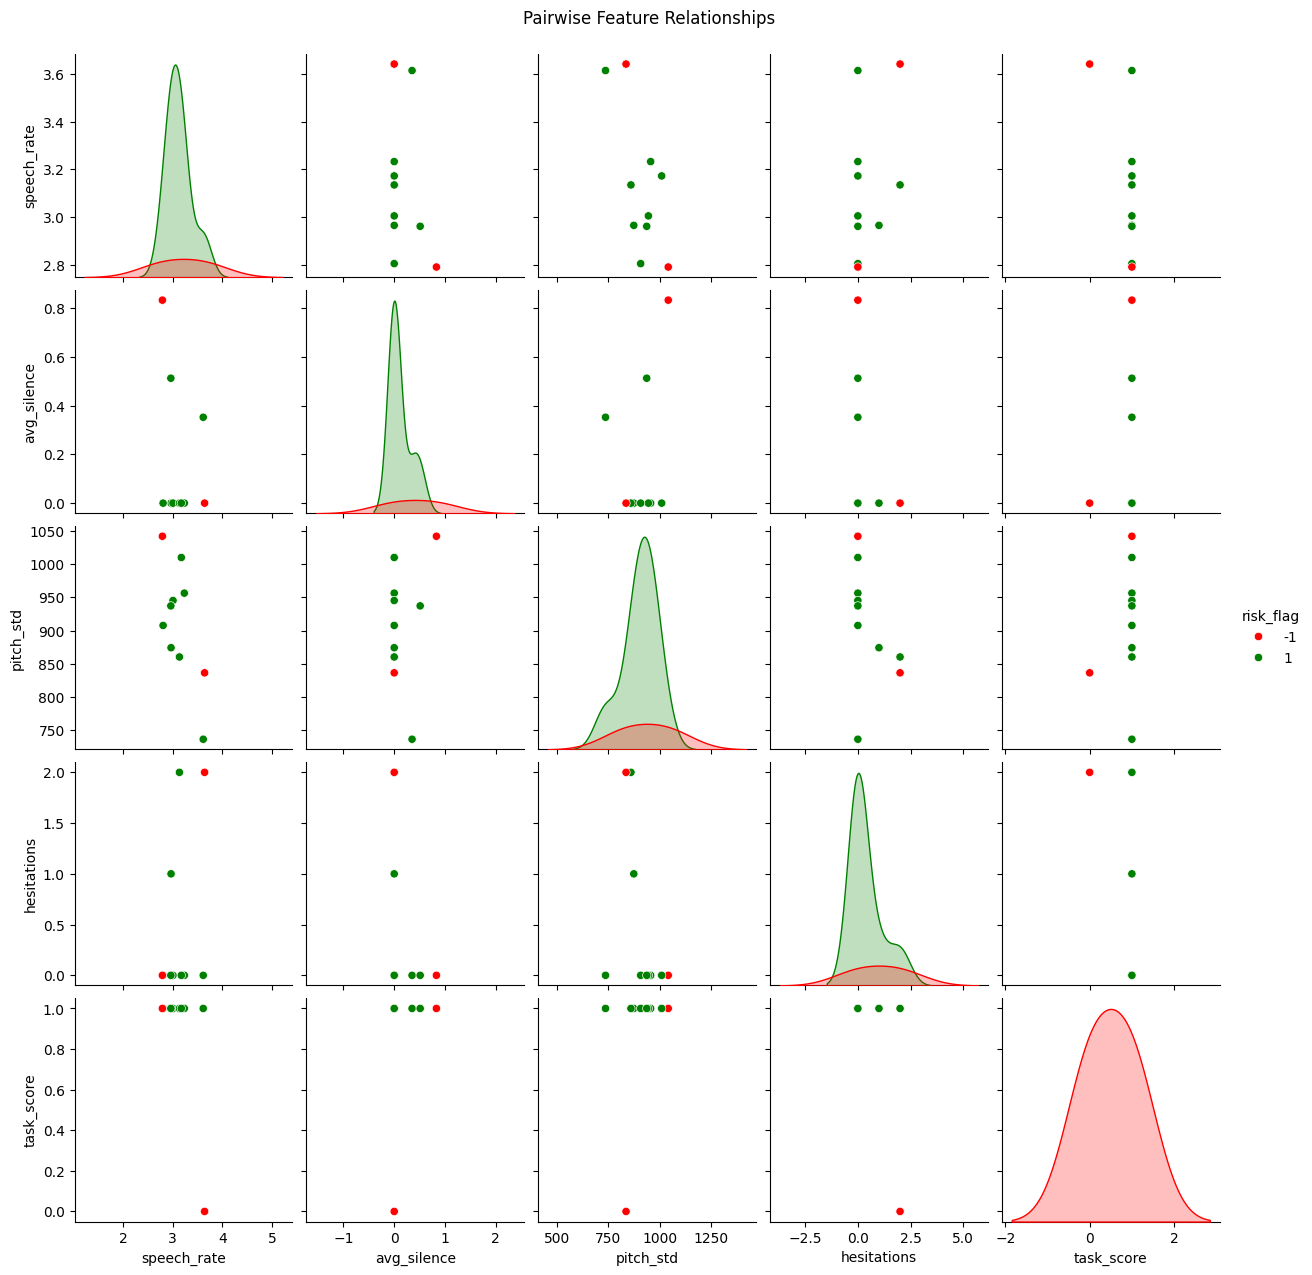

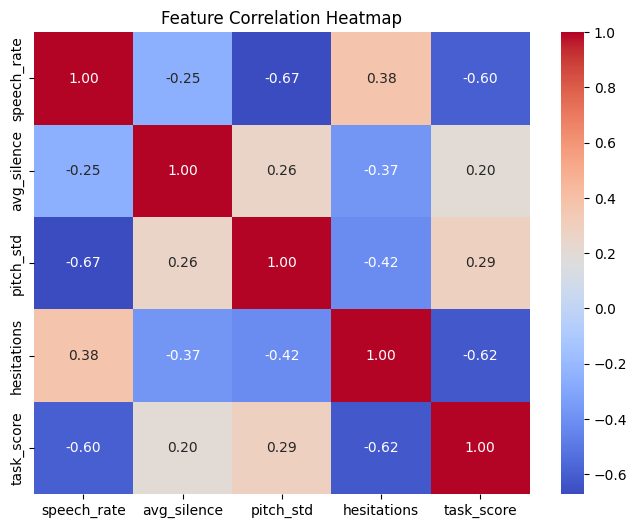

In [17]:
import seaborn as sns

# Pairplot (great for unsupervised tasks)
sns.pairplot(df[features_for_model + ["risk_flag"]], hue="risk_flag", palette={1: "green", -1: "red"})
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

# OR Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[features_for_model].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


✅ API-Ready Version

In [ ]:
import shutil
import os

# ========== API-READY: SINGLE FILE RISK SCORING FUNCTION ==========
def get_risk_score(file):
    file_location = f"temp_{file.filename}"

    # Save the uploaded audio file temporarily
    with open(file_location, "wb") as buffer:
        shutil.copyfileobj(file.file, buffer)

    # Check if corresponding .meta file exists
    meta_path = file_location.replace(".wav", ".meta")
    if os.path.exists(meta_path):
        shutil.copy(meta_path, file_location.replace("temp_", "voice_samples/"))

    # Extract features using temp audio file
    f = extract_features(file_location)
    x = scaler.transform([[f["speech_rate"], f["avg_silence"], f["pitch_std"], f["hesitations"], f["task_score"]]])
    score = iso_model.decision_function(x)[0]
    label = iso_model.predict(x)[0]

    # Clean up temp file
    os.remove(file_location)

    return {
        "file": f["file"],
        "transcript": f["transcript"],
        "speech_rate": f["speech_rate"],
        "pitch_std": f["pitch_std"],
        "avg_silence": f["avg_silence"],
        "hesitations": f["hesitations"],
        "task_type": f["task_type"],
        "task_score": f["task_score"],
        "risk_score": float(score),
        "flagged": bool(label == -1)
    }


### FastAPI Endpoint Example

In [ ]:
from fastapi import FastAPI, UploadFile
import uvicorn

app = FastAPI()

@app.post("/analyze/")
async def analyze_audio(file: UploadFile):
    return get_risk_score(file)

# Run with:
# uvicorn myscript:app --reload
